In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.layers import Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [39]:
x_train.shape

(60000, 28, 28)

In [40]:
import random

In [41]:
# 构建正样本pair和负样本pair
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []

    for d in range(10):
        for i in range(d):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1] #  构建正样本
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] # 构建负样本
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]

    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):

    digit_indices = [np.where(labels == i)[0] for i in range(10)] # 每个类的index 
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')

    return pairs, y

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize values
x_train = x_train / 255.0
x_test = x_test / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(x_train, y_train)
ts_pairs, ts_y = create_pairs_on_set(x_test, y_test)

sequential model

In [42]:
# Implemented with sequential API
def initialize_base_network_seq():
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(28, 28, ), name="base_input"))
    model.add(Flatten(name="flatten_input"))
    model.add(Dense(128, activation='relu', name="first_base_dense"))
    model.add(Dropout(0.1, name="first_dropout"))
    model.add(Dense(128, activation='relu', name="second_base_dense"))
    model.add(Dropout(0.1, name="second_dropout"))
    model.add(Dense(128, activation='relu', name="third_base_dense"))
    return model

Functional API 

In [43]:
def initialize_base_network_func():
    input_ = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input_)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input_, outputs=x)

Model Subclassing 

In [44]:
from tensorflow.keras import Model

class BaseNetwork(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.flatten_input = Flatten(name="flatten_input")
        self.first_base_dense = Dense(128, activation='relu', name="first_base_dense")
        self.first_dropout = Dropout(0.1, name="first_dropout")
        self.second_base_dense = Dense(128, activation='relu', name="second_base_dense")
        self.second_dropout = Dropout(0.1, name="second_dropout")
        self.third_base_dense = Dense(128, activation='relu', name="third_base_dense")

    def call(self, input_):
        output = self.flatten_input(input_)
        output = self.first_base_dense(output)
        output = self.first_dropout(output)
        output = self.second_base_dense(output)
        output = self.second_dropout(output)
        output = self.third_base_dense(output)
        return output
    
    # 对于 model subclassing 实现的模型，如果只实现了 __init__() 和 call() 方法，那么将不能进行可视化，必须再实现 build_graph() 方法
    def build_graph(self, input_shape):
        input_ = tf.keras.layers.Input(shape=input_shape)
        return Model(inputs=[input_], outputs=self.call(input_))

输出层

In [45]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# 函数不能直接作为数据层使用，需要将此层变成 layer 才能使用。具体要如何构建layer，有两种方式。
# Layer Subclassing
# Lambda 实现

Layer subclassing 实现 Euclidean Distance Layer 层

In [46]:
# create customized layer
class CustomizedEuclideanDistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        '''构建所需要的参数'''
        super().build(input_shape)
        # 这边没有

    def call(self, inputs):
        '''完成正向计算'''
        return euclidean_distance(inputs)

Lambda 实现 Euclidean Distance Layer 层（output层）

In [47]:
euclidean_dis_layer_lambda = Lambda(euclidean_distance, name="outpur_layer", output_shape=(1, 1))

构建 siamese model

方式一：Functional API

In [48]:
# create the left input and point to the base network
input_1 = Input(shape=(28,28), name="left_input")
base_network = initialize_base_network_func()
embedding1 = base_network(input_1)

# create the right input and point to the base network
input_2 = Input(shape=(28,28), name="right_input")
embedding2 = base_network(input_2)


## Implemented with Functional API
# measure the similarity of the two vector outputs
output = euclidean_dis_layer_lambda([embedding1, embedding2])

# specify the inputs and output of the model
model = Model([input_1, input_2], output)

方式二：Model Subclassing

In [49]:
#### Implemented with subclass API

class SiameseModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.base_model = BaseNetwork()
        self.euclidean_dis_layer = Lambda(euclidean_distance, name="outpur_layer", output_shape=(1, 1))

    def call(self, inputs):
        input_1, input_2 = inputs

        embedding1 = self.base_model(input_1)
        embedding2 = self.base_model(input_2)

        output = self.euclidean_dis_layer([embedding1, embedding2])
        return output

    def build_graph(self, shapes):
        shape1, shape2 = shapes
        input_1 = tf.keras.layers.Input(shape=shape1)
        input_2 = tf.keras.layers.Input(shape=shape2)
        return Model(inputs=[input_1, input_2], outputs=[self.call([input_1, input_2])])

model = SiameseModel()    

Train the Model

In [50]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square) # 正样本pair越小，让负样本pair 距离越大，且必须要大于margin，否则的话 所有 y_predict 都等于0，loss也是0
    return contrastive_loss

In [51]:
from tensorflow.keras.optimizers import RMSprop

In [52]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=5, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/5
1/1 [==============================] - 0s 166ms/step - loss: 1.7439 - val_loss: 0.3828
Epoch 2/5
1/1 [==============================] - 0s 64ms/step - loss: 0.6462 - val_loss: 0.2356
Epoch 3/5
1/1 [==============================] - 0s 53ms/step - loss: 0.2631 - val_loss: 0.2366
Epoch 4/5
1/1 [==============================] - 0s 61ms/step - loss: 0.2253 - val_loss: 0.2243
Epoch 5/5
1/1 [==============================] - 0s 51ms/step - loss: 0.1952 - val_loss: 0.2208


验证效果

In [53]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [54]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

3/3 [==============================] - 0s 3ms/step - loss: 0.2208
Loss = 0.22082214057445526, Train Accuracy = 0.7888888888888889 Test Accuracy = 0.6666666666666666


展示图片

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

展示模型效果

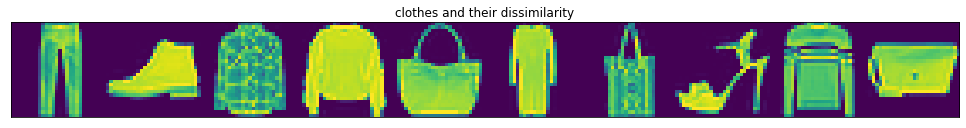

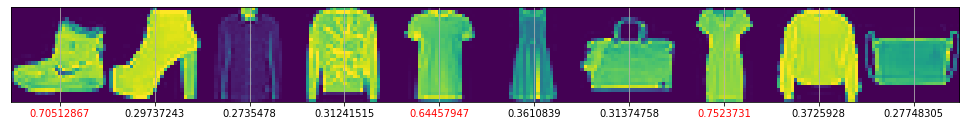

In [57]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)